# Predict Podcast Listening Time
Kaggle Playground Series - Season 5, Episode 4

## Imports & Data loading

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

from xgboost import XGBRegressor

In [2]:
full_train = pd.read_csv("train.csv", index_col="id")
full_test = pd.read_csv("test.csv", index_col="id")

y = full_train["Listening_Time_minutes"]
X = full_train.drop("Listening_Time_minutes", axis = 1)

In [3]:
full_train

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...
749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [6]:
X_train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
id,,,,,,,,,,
58797,Fitness First,Episode 8,67.60,Health,60.32,Monday,Night,NaN,1.0,Negative
350030,Humor Hub,Episode 68,34.00,Comedy,58.71,Tuesday,Morning,47.74,3.0,Negative
714763,Sports Weekly,Episode 92,45.15,Sports,29.48,Saturday,Evening,NaN,3.0,Positive
251121,True Crime Stories,Episode 24,83.70,True Crime,63.86,Saturday,Evening,NaN,3.0,Negative
428721,Lifestyle Lounge,Episode 4,99.32,Lifestyle,25.77,Friday,Morning,28.01,0.0,Neutral


## Data insights

Podcast_Name                      48
Episode_Title                    100
Episode_Length_minutes         12141
Genre                             10
Host_Popularity_percentage      8031
Publication_Day                    7
Publication_Time                   4
Guest_Popularity_percentage    10010
Number_of_Ads                     10
Episode_Sentiment                  3
dtype: int64


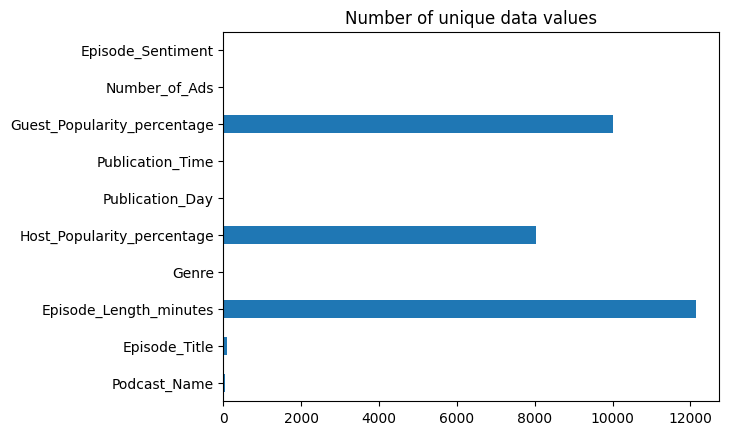

In [7]:
print(X_train.nunique())
X_train.nunique().plot(kind="barh", title = "Number of unique data values")
plt.show()

Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          69676
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    116866
Number_of_Ads                       1
Episode_Sentiment                   0
dtype: int64


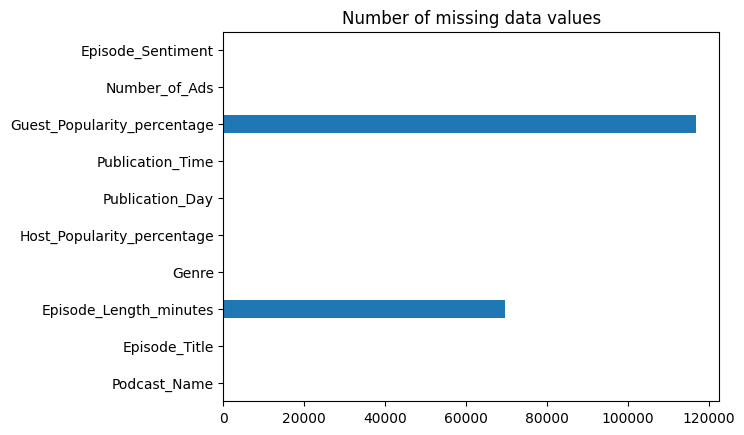

In [8]:
print(X_train.isnull().sum())
X_train.isnull().sum().plot(kind = "barh", title = "Number of missing data values")
plt.show()

## Data Preparation Pipeline

In [9]:
# Getting numerical features
num_features = [col for col in X_train.columns if X_train[col].dtype == "float64"]
num_features

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads']

In [10]:
# Function to turn "object" types to "category" types
def obj_to_cat(df):

    """Converts DataFrame columns from 'object' types to 'category' types"""

    cat_features = [col for col in df.columns if df[col].dtype == "object"]
    
    for cat_feat in cat_features:
        df[cat_feat] = df[cat_feat].astype("category")
    
    return df

obj_to_cat(X_train)
obj_to_cat(X_val)

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
id,,,,,,,,,,
629436,Finance Focus,Episode 3,30.63,Business,33.91,Wednesday,Morning,45.91,1.0,Neutral
525015,Innovators,Episode 3,NaN,Technology,70.42,Tuesday,Afternoon,32.04,3.0,Positive
114041,Daily Digest,Episode 45,97.71,News,22.66,Friday,Evening,3.74,3.0,Positive
523286,Business Briefs,Episode 92,56.12,Business,26.12,Friday,Night,13.82,0.0,Positive
613265,Healthy Living,Episode 8,75.97,Health,88.31,Monday,Morning,NaN,0.0,Neutral
...,...,...,...,...,...,...,...,...,...,...
710298,Tune Time,Episode 70,NaN,Music,91.65,Tuesday,Morning,NaN,1.0,Neutral
697264,Tech Talks,Episode 88,21.08,Technology,51.34,Monday,Morning,NaN,1.0,Negative
647026,World Watch,Episode 42,38.44,News,44.03,Friday,Night,95.41,0.0,Negative


In [ ]:
cat_features = [col for col in X_train.columns if X_train[col].dtype == "category"]

categorical_encoder = Pipeline(steps = [
    ("label_encoder", LabelEncoder())
])

preprocessor = ColumnTransformer(
    transformers = [("cat", categorical_encoder, cat_features)]
)

model = XGBRegressor(n_estimators=1000, 
                     learning_rate=0.1, 
                     enable_categorical = True)


my_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
    ])

my_pipeline.fit(X_train, y_train)

preds = my_pipeline.predict(X_val)


RMSE =  root_mean_squared_error(y_val, preds)
RMSE


TypeError: LabelEncoder.fit_transform() takes 2 positional arguments but 3 were given

In [17]:
# Label encoded the categorical features. Not using OH encoding to reduce training time.

cat_features = [col for col in X_train.columns if X_train[col].dtype == "category"]

label_encoder = LabelEncoder()

for cat_feat in cat_features:
    X_train[cat_feat] = label_encoder.fit_transform(X_train[cat_feat])
    X_val[cat_feat] = label_encoder.transform(X_val[cat_feat])

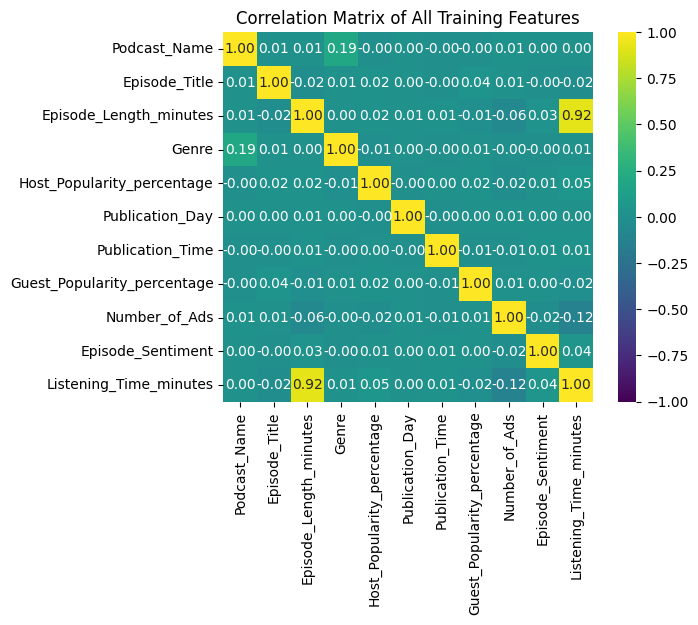

In [18]:
# Creating Feature and Answer pairs for the correlation matrix
feat_label_pair = pd.concat([X_train,y_train], axis = 1)

correlation_matrix = feat_label_pair.corr()
heatmap = sns.heatmap(correlation_matrix, 
                      annot = True,
                      vmin = -1,
                      vmax = 1,
                      center = 0,
                      cmap = "viridis",
                      fmt = ".2f",
                      square = True)
plt.title("Correlation Matrix of All Training Features")
plt.show()

In [ ]:
#num_imputer = SimpleImputer(strategy="most_frequent")

#X_train["Episode_Length_minutes"] = num_imputer.fit_transform(pd.DataFrame(X_train["Episode_Length_minutes"]))
#X_val["Episode_Length_minutes"] = num_imputer.transform(pd.DataFrame(X_val["Episode_Length_minutes"]))

## Model Training and Testing

In [ ]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.1, enable_categorical = True)
model.fit(X_train, y_train)
preds = model.predict(X_val)

RMSE =  root_mean_squared_error(y_val, preds)
RMSE

12.925159910125323

In [ ]:
# first try, no cat or num imputing: 13.088236576209288
# with label encoding: 13.031150146367553
# With mean numeric imputing it gets worse: 13.127882377464248
# improved xgb: n = 1000, lr = 0.1: 12.925159910125323